<a href="https://colab.research.google.com/github/ileniagalati/computer_vision_project/blob/main/FINALE_Cable_and_towel_detection_and_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cable and towel detection and segmentation
Carmen D'Agostino, Ilenia Galati


---



Il progetto di Computer Vision 2024 consiste nella costruzione di un modello di segmentazione per l'identificazione dei pixel di cavi e torri presenti nel nostro dataset.  

## Il dataset, analisi e considerazioni

Il dataset comprende una serie di immagini che raffigurano una rete di distribuzione elettrica, in particolare l'attenzione è rivolta a torri di trasmissione e linee elettriche.

Iniziamo il nostro studio con una fase preliminare di analisi del dataset, in modo da comprendere al meglio le proprietà delle immagini a nostra disposizione.  
Carichiamo quindi il dataset e otteniamo da esso qualche informazione preliminare.

In [13]:
# Importiamo alcune librerie utili
import tensorflow as tf
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Collegamento al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Il dataset è costituito da due insiemi di immagini:
- il training set
- il test set

Essi sono memorizzati in due cartelle diverse. Tali cartelle contengono tutte le immagini che costituiscono il training/test set e un file in formato COCO che memorizza tutte le informazioni delle immagini. In particolare il dataset annota le immagini usando la segmentazione per istanza: per ogni istanza di oggetto presente in un'immagine vengono indicati l'etichetta, il bounding box e la maschera di segmentazione.

Leggiamo le immagini di tali set.

In [14]:
# Training set e test set path
train_path = '/content/drive/MyDrive/dataset_progetto_cv/trainingset'
test_path = '/content/drive/MyDrive/dataset_progetto_cv/testset'

train_file = 'train.json'
test_file =  'test.json'

In [4]:
# Caricamento del training set
with open(train_path+'/'+train_file, "r") as f:
    coco_data = json.load(f)

images = coco_data["images"]

# Memorizzazione delle immagini X del training set
X_train = []

for image in images:
    img = plt.imread(train_path+'/'+image["file_name"])
    X_train.append(img)

X_train = np.array(X_train)

In [5]:
# Stesse operazioni per il test set
with open(test_path+'/'+test_file, "r") as f:
    coco_data_test = json.load(f)

images = coco_data_test["images"]

X_test = []

for image in images:
    img = plt.imread(test_path+'/'+image["file_name"])
    X_test.append(img)

X_test = np.array(X_test)

Il test set e il training set sono formati rispettivamente da 842 e 400 immagini a colori di dimensione 700x700.

In [6]:
print(f"Dimensione del training set: {len(X_train)}")
print(f"Dimensione del test set: {len(X_test)}")
print(f"Dimensione delle immagini: {X_test[0].shape}")

Dimensione del training set: 842
Dimensione del test set: 400
Dimensione delle immagini: (700, 700, 3)


Le dimensioni del training e del test set sono abbastanza limitate. Questo può
rappresentare una sfida nell'implementazione di un buon modello. Infatti dataset troppo piccoli potrebbero non essere rappresentativi della diversità degli scenari reali e potrebbero compromettere la capacità del modello di generalizzare, aumentando il rischio di overfitting.
Di conseguenza la dimensione ridotta del training e del test set è sicuramente uno dei fattori di cui tenere in considerazione durante il nostro studio.  
  
  
Visualizziamo alcune delle immagini del training e del test set.  

Immagini training set:


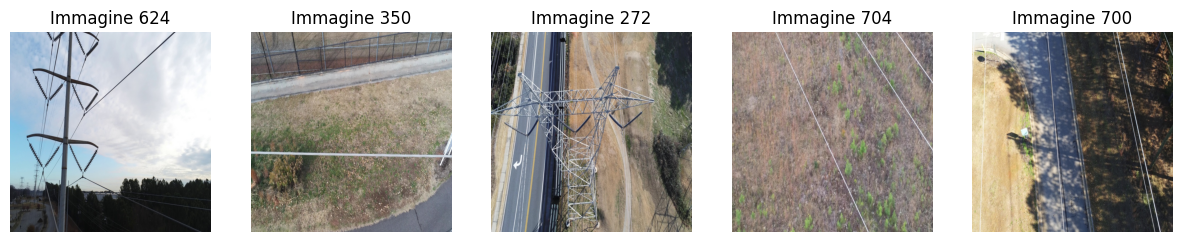

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, indice in enumerate(np.random.choice(len(X_train), 5, replace=False)):
    axs[i].imshow(X_train[indice])
    axs[i].set_title(f'Immagine {indice + 1}')
    axs[i].axis('off')

print("Immagini training set:")
plt.show()

Immagini test set:


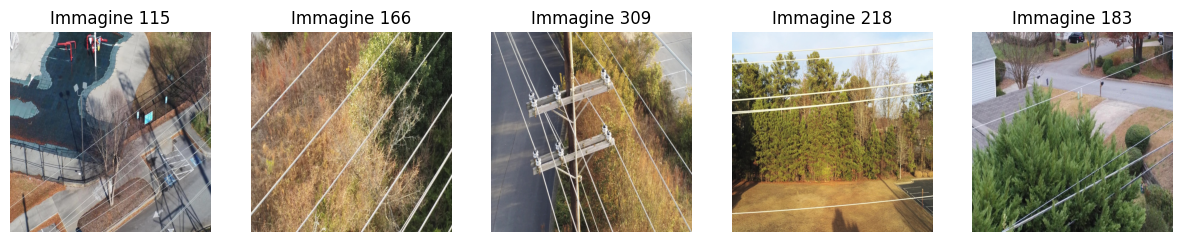

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, indice in enumerate(np.random.choice(len(X_test), 5, replace=False)):
    axs[i].imshow(X_test[indice])
    axs[i].set_title(f'Immagine {indice + 1}')
    axs[i].axis('off')

print("Immagini test set:")
plt.show()

Le istanze presenti nelle immagini del dataset possono essere etichettate con quattro diverse etichette:
  -	L'etichetta “tower-lattice” viene utilizzata per etichettare tutte le torri di trasmissione di forma reticolare.
  -	L’etichetta “tower-tucohy” viene utilizzata per le torri tubolari in acciaio (tu), in cemento (co) e ibridi acciaio/cemento (hy). Si suppone che questi tre tipi di torri appartengano alla stessa categoria.
  - L'etichetta “tower-woden” viene utilizzata per etichettare tutte le torri di trasmissione in legno.
  - L'etichetta "cable" viene utilizzata per tutte le linee elettriche.
  
Visualizziamo il numero di istanze per ogni categoria.

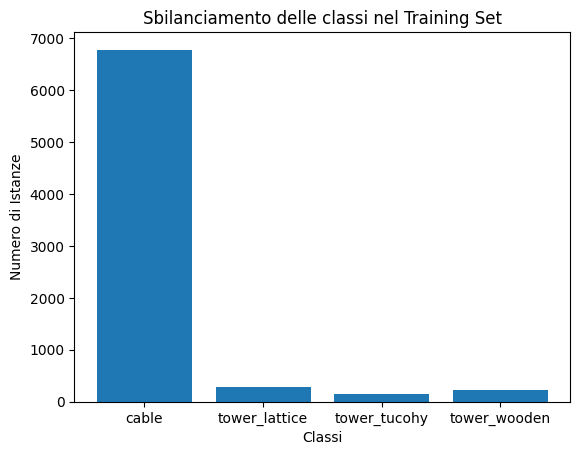

cable: 6775 istanze
tower_lattice: 276 istanze
tower_tucohy: 152 istanze
tower_wooden: 222 istanze


In [15]:
# Conteggio delle istanze per ogni classe nelle immagini del training set

annotations = coco_data["annotations"]

class_count = {category["name"]: 0 for category in coco_data["categories"]}

for annotation in annotations:
    category_name = [category["name"] for category in coco_data["categories"] if category["id"] == annotation["category_id"]][0]
    class_count[category_name] += 1

# Visualizziamo tramite un grafico
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Classi')
plt.ylabel('Numero di Istanze')
plt.title('Sbilanciamento delle classi nel Training Set')
plt.show()

for category, count in class_count.items():
    print(f"{category}: {count} istanze")

Dalle immagini e dal grafico notiamo che vi sono alcuni fattori da tenere in considerazione:

1.	*Somiglianza tra il colore dello sfondo e il colore dei cavi.*   
Questo potrebbe rendere molto difficile la detection dei cavi. Per risolvere questo problema la prima soluzione che ci viene in mente è utilizzare trasformazioni delle immagini, introducendo variazioni nei colori, nelle illuminazioni e nel contrasto. Ciò può contribuire a migliorare la capacità del modello di generalizzare.
2.	*Gli oggetti possono presentare strutture molto differenti.*  
Mentre i cavi presentano sempre la stessa struttura, le torri di trasmissione possono presentare strutture molto diverse tra loro. Ci aspettiamo quindi di ottenere risultati migliori nella detection dei cavi rispetto alla detection delle torri di trasmissione.
3.	*Squilibrio delle classi.*  
Ogni torre di trasmissione è collegata ad un alto numero di cavi elettrici. In effetti sono presenti molte più istanze di torri di trasmissione rispetto a istanze di cavi. Questo vuol dire che è necessario fare attenzione alle metriche che permettono di valutare i modelli. Una soluzione potrebbe essere quella di aggiungere nel nostro training set più immagini contenenti istanze di tralicci.


Dalle nostre riflessioni emerge che l'utilizzo della data augmentation potrebbe costituire una soluzione efficace per sviluppare un buon modello.



## Studio della letteratura

Per affrontare il nostro problema, il primo step è lo studio di architetture, modelli e strategie già presenti in letteratura per scegliere quelle più adatte al nostro task. In particolare, gli studi che abbiamo maggiormente preso in considerazione, prima di scegliere l'architettura finale, sono:

* YOLACT++: «TTPLA: An Aerial-Image Dataset for Detection and Segmentation of Transmission Towers and Power Lines»;
* Unet: «Transmission Line Segmentation Solutions for UAV Aerial Photography Based on Improved UNet»;
* Mask-RCNN: «Automatic Extraction of Power Lines from Aerial Images of Unmanned Aerial Vehicles».

Infine, scegliamo di eseguire il nostro task sfuttando il framework Detectron2, il quale, dopo aver esaminato i risultati ottenuti su altri studi, ci sembra molto promettente.

## Detectron 2


Detectron2 è un framework di computer vision. È stato sviluppato da Facebook AI Research per la creazione e l'addestramento di modelli di Object Detection e Segmentation.

Scarichiamo ed installiamo il framework dalla repository ufficiale.

In [16]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-4bamdiwu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-4bamdiwu
  Resolved https://github.com/facebookresearch/detectron2.git to commit 864913f0e57e87a75c8cc0c7d79ecbd774fc669b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119686 sha256=28ae514cefb05372217e3fd2217b5

In [17]:
#operazioni preliminari, verifichiamo la compatibilità delle versioni di torch e detectron
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [18]:
#iniziamo ad importare le librerie utili
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow


from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Prepariamo il dataset trasformandolo nel formato standard richiesto da Detectron2.  
Per consentire a Detectron2 di sapere come ottenere il dataset, è necessario implementare una funzione che restituisca gli elementi del dataset e comunicare al modello questa funzione:

In [19]:
from detectron2.structures import BoxMode
import json
import cv2
import os

def get_coco_dicts(path):
   if path=="train":
    path=train_path
    file=train_file
   elif path=="test":
      path=test_path
      file=test_file

   with open(path+'/'+file, "r") as f:
    coco_data = json.load(f)

    dataset_dicts = []
    for image_info in coco_data["images"]:
        record = {}

        record["file_name"] = os.path.join(path, image_info["file_name"])
        record["image_id"] = image_info["id"]
        record["height"] = image_info["height"]
        record["width"] = image_info["width"]

        objs = []
        for annotation_info in coco_data["annotations"]:
            if annotation_info["image_id"] == image_info["id"]:
                obj = {
                    "bbox": annotation_info["bbox"],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": annotation_info["segmentation"],
                    "category_id": annotation_info["category_id"],
                }
                objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

#get_coco_dicts("test")

Tale funzione deve restituire un list[dict] con una struttura molto simile alle annotazioni COCO.  
I campi che è obbigatorio inserire nel dict dipendono dal tipo di attività che deve essere eseguita.   
Tra i campi che devono essere inseriti vi sono:
- *file_name*: percorso completo dell'immagine.
- *height*, *width*: dimensioni dell'immagine.
- *image_id*: un ID univoco che identifica l'immagine.
- *annotations*: annotazioni per le attività di segmentazione. Ogni annotazione può contenere i seguenti campi:
 - *bbox*: elenco di 4 numeri che rappresentano il riquadro di delimitazione dell'istanza.
 - *bbox_mode*: il formato di bbox. BoxMode.XYWH_ABS indica che la bounding box è indicata da: coordinate del centro, larghezza e altezza. Nel nostro dataset le bbox sono espresse proprio in questo formato.
 - *category_id*: un numero intero nell'intervallo [0, num_categories-1] che rappresenta l'etichetta della categoria.
 - *segmentation*: maschera di segmentazione dell'istanza. In questo caso viene rappresentato come list[list[float]] in cui ogni list[float] è un poligono nella forma [x1, y1, ... , xn, yn]. Una coppia (xi, yi) rappresenta uno dei vertici del poligono.

Ci assicuriamo che gli id delle diverse categorie siano ben interpretati dal modello. Spesso molti modelli di computer vision riservano il primo o l'ultimo id alla categoria "background". Detectron2 offre la possibilità di customizzare la scelta, quindi cominciamo la numerazione con "cable" la prima categoria.

Per poter utilizzare il dataset abbiamo bisogno di "registrarlo" nel catalogo del framework insieme ai relativi metadati:

In [20]:
for d in ["train","test"]:
  DatasetCatalog.register("ttpla_"+d, lambda d=d: get_coco_dicts("train") if d=="train" else get_coco_dicts( "test"))
  MetadataCatalog.get("ttpla_"+d).set(thing_classes=["cable","tower_lattice","tower_tucohy","tower_wooden"])
ttpla_metadata = MetadataCatalog.get("ttpla_train")

Visualizziamo le annotazioni di tre istanze scelte casualmente dal dataset per verificare che il dataset è nel corretto formato:

/content/drive/MyDrive/dataset_progetto_cv/trainingset/80_1230.jpg


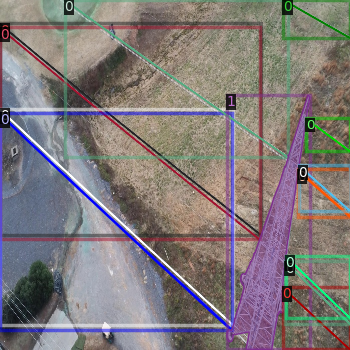

/content/drive/MyDrive/dataset_progetto_cv/trainingset/23_00706.jpg


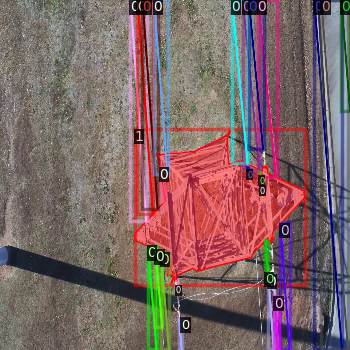

/content/drive/MyDrive/dataset_progetto_cv/trainingset/48_01636.jpg


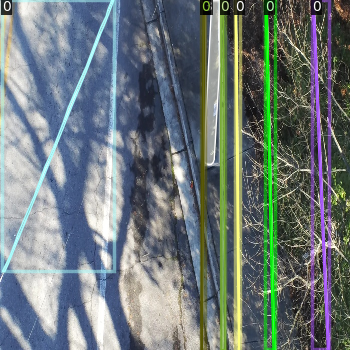

In [ ]:
dataset_dicts = get_coco_dicts("train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Addestramento del modello

Abbiamo scelto di procedere provando vari modelli preaddestrati, già forniti da Detectron2, i quali non hanno però avuto prestazioni abbastanza soddisfacenti:

*   "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"
*   "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
*   "configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

Il modello finale, che abbiamo deciso di addestrare è "mask_rcnn_X_101_32x8d_FPN_3x.yaml", che fa parte della famiglia dei modelli Mask R-CNN.

L'architettura del modello (che vediamo stampata durante l'addestramento) presenta:

*   Backbone di base: ResNet-X-101-32x8d. È una variante di ResNet con il nome specifico "XCeption-101-32x8d", indicando il numero di layer (101) e il numero di canali (32x8) nei primi strati convoluzionali. È configurato per utilizzare una profondità di 101 layer con una dimensione di 8 volte il numero di canali.

*   Feature Pyramid Network (FPN): integra le feature maps provenienti dai livelli più profondi della backbone. Queste feature maps vengono utilizzate per affrontare il problema delle scale, permettendo al modello di rilevare oggetti di diverse dimensioni.

* Region Proposal Network (RPN): genera proposte di regioni dell'immagine che potrebbero contenere oggetti di interesse.

* RoI Align: la  Region of Interest (RoI) Align è utilizzata per l'estrarre feature in corrispondenza delle regioni di interesse. Questo processo consente al modello di focalizzarsi sulle regioni rilevanti per i task di segmentazione e classificazione.

La loss totale invece è data dalla somma di loss di classificazione, loss sul task di regressione (bounding box) e loss sul task di segmentazione (individuazione delle maschere), definite come per il modello originale di Mask-RCNN:

* Task di Classificazione: Cross Entropy Loss
* Task di Regressione: SmoothL1 Loss
* Task di Segmentazione: Binary Cross Entropy Loss

  


---


**Fine-tuning**  
Conduciamo una serie di prove al fine di identificare i parametri del modello che sembrano favorire il raggiungimento di risultati migliori e infine scegliamo di addestrare il modello utilizzando i seguenti parametri.

In [ ]:
output_path = "/content/drive/MyDrive/output"

In [ ]:
from detectron2.engine import DefaultTrainer

# parametri che si possono configurare: https://detectron2.readthedocs.io/en/latest/modules/config.html#detectron2.config.CfgNode

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")) #possiamo scegliere il modello nella repository: detectron2/MODEL_ZOO.md
cfg.DATASETS.TRAIN = ("ttpla_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4    #batch_size
cfg.SOLVER.BASE_LR = 0.001      #learning rate
cfg.SOLVER.MAX_ITER = 18000     #iterazioni massime
cfg.SOLVER.STEPS = []           #eventuali step intermedi
cfg.SOLVER.OUTPUT_DIR=output_path
cfg.OUTPUT_DIR=output_path
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  #numero di classi
cfg.SOLVER.CHECKPOINT_PERIOD=1000    #salvataggio intermedio dei checkpoint, ogni 1000 iterazioni

os.makedirs(cfg.SOLVER.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)

print(f"Output directory: {cfg.OUTPUT_DIR}")
print(f"Output directory solver: {cfg.SOLVER.OUTPUT_DIR}")
print(f"Checkpoints in the directory: {os.listdir(cfg.OUTPUT_DIR)}")

trainer.resume_or_load(resume=True) #true perchè vogliamo ripartire dall'ultimo checkpoint presente nella cartella output
print("Checkpoint loaded. Starting training...")
trainer.train() #iniziamo il training

[01/19 08:17:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Inferenza e valutazione del modello


In questa sezione effettuiamo l'inferenza sul test set, stampiamo qualche risultato di esempio e calcoliamo il numero di parametri del modello appena addestrato.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path al modello che abbiamo addestrato
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[01/19 08:18:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


In [ ]:
#stampiamo il numero di parametri
from torch.nn.utils import parameters_to_vector
print(parameters_to_vector(predictor.model.parameters()).numel())
pytorch_total_params = sum(p.numel() for p in predictor.model.parameters() if p.requires_grad)
print(pytorch_total_params)

107018728
106593576


Selezioniamo casualmente alcuni esempi per visualizzare i risultati del modello.

/content/drive/MyDrive/dataset_progetto_cv/testset/27_00772.jpg


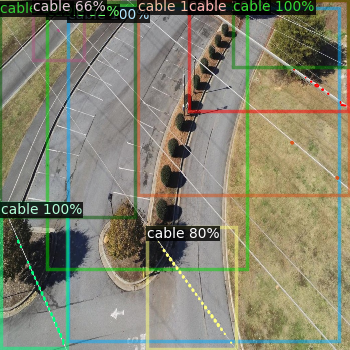

/content/drive/MyDrive/dataset_progetto_cv/testset/32_4860.jpg


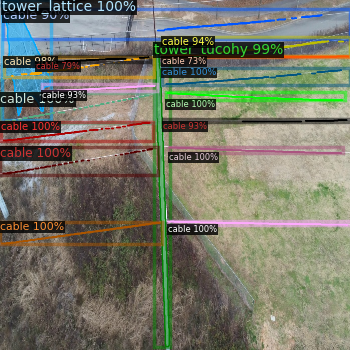

/content/drive/MyDrive/dataset_progetto_cv/testset/16_3720.jpg


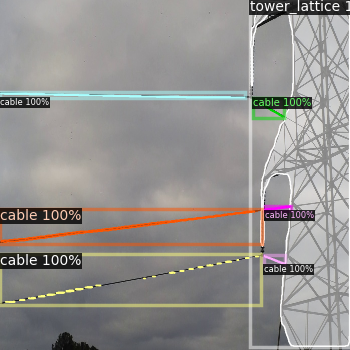

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = get_coco_dicts("test")
for d in random.sample(dataset_dicts_test, 3):
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ttpla_metadata,
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#effettuiamo una valutazione delle prestazioni del modello, quindi con batch pari ad 1
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ttpla_test", output_dir=output_path)
val_loader = build_detection_test_loader(cfg, "ttpla_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

Addestrando il modello per circa 85 epoche riusciamo a raggiungere degli score di AP50% di:

*  box: 59.5
*  mask: 40.5

Notiamo soprattutto un basso score di segmentazione sulla categoria "cable".
Vogliamo quindi tentare di migliorare ancora le prestazioni del modello e lo facciamo attraverso le tecniche di data augmentation.

## Data Augmentation


Al fine di ottimizzare le soglie di rilevamento, abbiamo implementato la tecnica di data augmentation sul nostro dataset. Per farlo generiamo nuove immagini, le quali vengono successivamente integrate al set di addestramento originale. Per ottenere tali immagini, selezioniamo casualmente campioni dal set di addestramento originale e applichiamo loro una serie di trasformazioni al fine di ottenere delle variazioni. L'utilizzo della data augmentation contribuisce a potenziare la capacità del modello di generalizzare su un insieme più esteso di scenari.

In [ ]:
# funzione che restituisce il dataset aumentato
# prende come argomento un T.Augmentation che definisce le operazioni che devono essere eseguite per trasformare i dati
# e N che indica il numero di immagini selezionate casualmente dal training set per essere trasformate, indica quindi la dimensione del dataset aumentato
def get_aug_data(augs,N):

    dataset_aug_dict = []

    # caricamento il training set
    training_set = get_coco_dicts("train")

    for image_info in random.sample(training_set, N):
      # lettura dell'immagine
      image = plt.imread(image_info["file_name"])

      # lettura delle annotazioni
      annotations = image_info["annotations"]

      # costruzione delle liste boxes e sem_seg
      boxes = []
      sem_seg = []

      for ann in annotations:
        x_min, y_min, width, height = ann["bbox"]

        # trasformazione delle coordinate in XYXY_ABS mode
        x_max = x_min + width
        y_max = y_min + height

        boxes.append([x_min, y_min, x_max, y_max])
        sem_seg.append(ann["segmentation"])

      sem_seg = np.array(sem_seg) # conversione a ndarray

      # definizione dell'input dell'augmentation
      input = T.AugInput(image,boxes=boxes,sem_seg=sem_seg)  # input (type AugInput) memorizza l'input a cui devono essere applicate le trasformazioni

      # applicazione dell'augmentation
      transform = augs(input)  # type: T.Transform  # si applica l'augmentation all'input e si ottiene l'oggetto T.Trasnform
                               # il quale memorizza le operazioni effettive per la augmentation
      # otteniamo la nuova immagine trasformata con i nuovi bbox e le nuove maschere
      image_transformed = input.image
      boxes_transformed = input.boxes
      sem_seg_transformed = input.sem_seg

      # Salvataggio dell'immagine trasformata
      save_path = os.path.join(aug_dir,'aug_'+os.path.basename(image_info["file_name"]))
      plt.imsave(save_path, image_transformed)

      # Aggiunta dell'immagine al dataset aumentato usando il formato richiesto dal modello
      record = {}

      record["file_name"] = save_path
      record["image_id"] = image_info["image_id"]+len(training_set)    # genero dei nuovi id a partire dalla dimensione del training set
      record["height"] = image_info["height"]
      record["width"] = image_info["width"]

      objs = []
      for i, bbox in enumerate(boxes_transformed):
              x, y, x_max, y_max = bbox

              # Conversione a XYWH_ABS
              w = x_max - x
              h = y_max - y
              obj = {
                  "bbox": [x, y, w, h],
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "segmentation": sem_seg_transformed[i].tolist() if len(sem_seg_transformed) > i else None,        # assumiamo che ci sia una corrispondenza tra bbox e maschere
                  "category_id": annotations[i]["category_id"],  # l'etichetta dovrebbe rimanare la stessa di quella dell'img di partenza (image)
              }
              objs.append(obj)

      record["annotations"] = objs
      dataset_aug_dict.append(record)

      # Salvataggio delle annotazioni del dataset
      file_path = '/content/drive/MyDrive/augmentation/augmented_data.json'
      aug_dataset_file = open(file_path, "w")
      json.dump(dataset_aug_dict, aug_dataset_file)
      aug_dataset_file.close()

    return

#get_aug_data(augs,10)

In [ ]:
# Creazione di una cartella in cui salvare le immagini trasformate
aug_dir = '/content/drive/MyDrive/augmentation'
os.makedirs(aug_dir, exist_ok=True)

Dopo una serie di prove, scegliamo la sequenza di trasformazioni da applicare alle immagini:

  - Flip orizzontale/verticale: specchiamo l'immagine per gestire la simmetria degli oggetti.

  - Cambiamento di luminosità, contrasto e saturazione: cambiamo la luminosità, la saturazione e il contrasto delle immagini per gestire variazioni nelle condizioni di illuminazione. Queste trasformazioni sono molto utili per gestire la somiglianza tra il colore dello sfondo e il colore dei cavi.

Abbiamo inoltre considerato altre trasformazioni, quali rotazioni, zoom e crop. Tuttavia, i risultati indicavano che l'implementazione di tali operazioni non apportava miglioramenti significativi alle prestazioni del modello. Va notato che il nostro dataset già includeva diverse immagini della stessa area, catturate da diverse angolazioni e distanze. Ciò ci ha portato a ipotizzare che tali trasformazioni aggiuntive potessero non essere essenziali.

In [ ]:
from detectron2.data import transforms as T

# Definizione di una seguenza di augmentations:
augs = T.AugmentationList([
    T.RandomFlip(prob=0.5),         # Flip dell'immagine
    T.RandomContrast(0.5, 1.5),     # Modifica del contrasto tra 0.5 e 1.5
    T.RandomBrightness(0.5, 1.5),   # Modifica della luminosità tra 0.5 e 1.5
    T.RandomSaturation(0.5,1.5)     # Modifica della saturazione tra 0.5 e 1.5
])  # type: T.Augmentation      # inglobba al suo interno la serie di operazioni che devono essere eseguite per trasformare i dati

In [ ]:
# Impostazione del numero di immagini su cui fare augmentation
N = 100

In [ ]:
# Creazione del dataset aumentato. Eseguire solo una volta
#get_aug_data(augs,N)

Abbiamo quindi costruito la funzione che permette di ottenere il dataset contenente le immagini trasformate.
Il numero di tali immagini è anch'esso un parametro da scegliere. Per ora iniziamo considerando 100 immagini trasformate. Evitiamo di utilizzare un elevato numero di immagini aumentate per impedire che il modello vada in overfitting.
  
Costruiamo il nuovo dataset aumentato, aggiungendo al dataset originale le immagini ottenute.

In [ ]:
# funzione che legge il dataset aumentato
def read_aug_dicts(path):
    aug_dict = open(path, "r")
    return json.load(aug_dict)

#read_aug_dicts('/content/drive/MyDrive/augmentation/augmented_data.json')


In [ ]:
aug_data_path = '/content/drive/MyDrive/augmentation/augmented_data.json'

# funzione che restituisce il dataset finale
def get_total_data():
  original_data = get_coco_dicts("train")
  print(f"len originale: {len(original_data)}")
  aug_data = read_aug_dicts(aug_data_path)
  for data in aug_data:
    original_data.append(data)
  return original_data
  print(f"len augmented: {len(original_data)}")

In [ ]:
# Registrazione del dataset

DatasetCatalog.register("ttpla_augmented", lambda d=d: get_total_data())
MetadataCatalog.get("ttpla_augmented").set(thing_classes=["cable","tower_lattice","tower_tucohy","tower_wooden"])

namespace(name='ttpla_augmented',
          thing_classes=['cable',
                         'tower_lattice',
                         'tower_tucohy',
                         'tower_wooden'])

Addestriamo nuovamente il modello per valutare eventuali miglioramenti.

In [ ]:
output_path= '/content/drive/MyDrive/output_aug'

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ttpla_augmented")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 3    # batch size
cfg.SOLVER.BASE_LR = 0.001      # learning rate
cfg.SOLVER.MAX_ITER = 20000     # iterazioni massime
cfg.SOLVER.STEPS = []
cfg.SOLVER.OUTPUT_DIR=output_path
cfg.OUTPUT_DIR=output_path
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4   # numero di classi
cfg.SOLVER.CHECKPOINT_PERIOD=1000

os.makedirs(cfg.SOLVER.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)

print(f"Output directory: {cfg.OUTPUT_DIR}")
print(f"Output directory solver: {cfg.SOLVER.OUTPUT_DIR}")
print(f"Checkpoints in the directory: {os.listdir(cfg.OUTPUT_DIR)}")

trainer.resume_or_load(resume=True) #True
print("Checkpoint loaded. Starting training...")
trainer.train()

Valutiamo il modello.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[01/18 23:54:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output_aug/model_final.pth ...


Visualizziamo alcune immagini per visualizzare i risultati.

/content/drive/MyDrive/dataset_progetto_cv/testset/38_00391.jpg


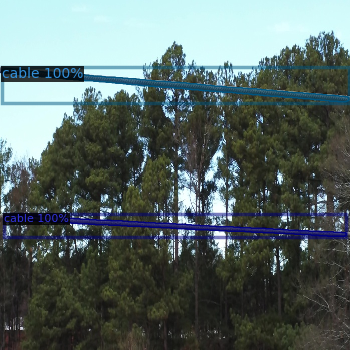

/content/drive/MyDrive/dataset_progetto_cv/testset/40_00401.jpg


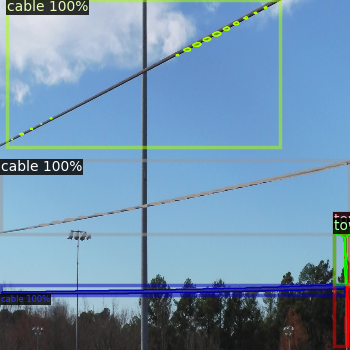

/content/drive/MyDrive/dataset_progetto_cv/testset/41_00621.jpg


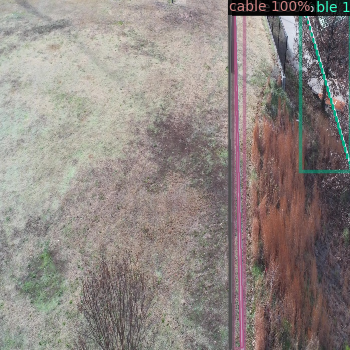

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = get_coco_dicts("test")
for d in random.sample(dataset_dicts_test, 3):
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ttpla_metadata,
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Addestrando il modello sul dataset aumentato con 100 nuove immagini abbiamo ottenuto i seguenti risultati.

Aumento di 100 immagini, a 20.000 iterazioni:
* box: 60.016
* mask: 39.190

Successivamente, abbiamo deciso di sperimentare ulteriormente, aumentando il numero di immagini del dataset a 200. Tuttavia i risultati hanno mostrato un peggioramento delle performance:

Aumento di 200 immagini, a 16.000 iterazioni:
* box: 59.738
* mask: 34.353

La diminuzione delle prestazioni può essere dovuta alla presenza di overfitting. L'aggiunta di ulteriori immagini potrebbe aver portato il modello a memorizzare caratteristiche specifiche del dataset di addestramento, rendendolo meno capace di riconoscere pattern più generali. Il cambiamento nel numero di immagini può richiedere un aggiornamento degli iperparametri del modello, come ad esempio il learning rate.

Decidiamo di procedere testando un'ultima tipologia di augmentation per cercare di migliorare le prestazioni.

## Detectron2 Augmentation

Proviamo ad utilizzare direttamente l'augmentation implementata in Detectron2. A differenza dell'approccio precedente, questo tipo di augmentation non consiste nel generare nuove immagini da aggiungere al training set originale. In questo caso le trasformazioni di data augmentation vengono applicate dinamicamente durante l'addestramento. In particolare le trasformazioni vengono applicate in tempo reale durante il caricamento dei dati, in modo che al modello vengano presentate nuove immagini durante ogni epoca di addestramento.

Questo approccio è molto più efficente in termini di memoria, in quanto non è necessario memorizzare nuove immagini.

Per implementare questo tipo di augmentation creiamo una nuova classe
denominata 'CustomTrainer', che riceve il 'DefaultTrainer' di Detrectron2. In questo modo possiamo personalizzare il modo in cui i dati vengono caricati al modello andando a ridefinire il metodo 'build_train_loader(cls, cfg)'. Questo metodo prende un mapper personalizzato, il quale applica una serie di trasformazioni di data augmentation a ciascun elemento del training set originale prima di passarlo al modello.

Le trasformazioni di data augmentation definite all'interno del mapper sono le stesse utilizzate nel precedente approccio di augmentation. Questo ci consentirà di confrontare direttamente le prestazioni dei modelli ottenuti.

In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)

    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4)
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


#custom_mapper(get_coco_dicts("train")[0])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
output_path= '/content/drive/MyDrive/output_aug4'

In [ ]:
os.makedirs(output_path, exist_ok=True)

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ttpla_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2  # Number of data loading threads
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 3    # batch size
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 24000
cfg.SOLVER.STEPS = []
cfg.SOLVER.OUTPUT_DIR=output_path
cfg.OUTPUT_DIR=output_path
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4   # numero di classi
cfg.SOLVER.CHECKPOINT_PERIOD=1000


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

Valutiamo il modello ottenuto.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = get_coco_dicts("test")
for d in random.sample(dataset_dicts_test, 6):
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ttpla_metadata,
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#effettuiamo una valutazione delle prestazioni del modello, quindi con batch pari ad 1
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ttpla_test", output_dir=output_path)
val_loader = build_detection_test_loader(cfg, "ttpla_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

Addestrando il modello per 24 000 riusciamo a raggiungere degli score di AP50% di:

- box: 58.349
- mask: 36.093

Nonostante l'aumento del numero di iterazioni di addestramento, abbiamo osservato un peggioramento delle prestazioni, sia per quanto riguarda i bounding box che per le maschere. Questo peggioramento si manifesta sia rispetto alla nostra precedente strategia di data augmentation, sia rispetto al modello che non utilizza affatto la data augmentation. Di conseguenza, siamo portati a escludere questa soluzione come opzione ottimale per il nostro task.

## Conclusioni




**Modello finale**  
Dalle analisi e dalle riflessioni condotte, giungiamo alla conclusione che il modello migliore tra quelli addestrati è il primo, il quale ci consente di ottenere le soglie più soddisfacenti. Pur constatando che quasi tutti i modelli hanno raggiunto prestazioni simili, abbiamo preferito il primo modello per la sua minor complessità e la capacità di ottenere risultati positivi con un numero inferiore di iterazioni, precisamente 18.000, con punteggi di bbox: 59.5 e segm: 40.5.
  

**Data Augmentation**  
Ci ha sorpreso il fatto che i modelli utilizzanti la tecnica di data augmentation non abbiano fornito risultati superiori. Questo fenomeno potrebbe derivare da diversi fattori.
  1. Considerare un numero elevato di immagini aumentate può causare un adattamento eccessivo del modello al training set, compromettendo la sua capacità di generalizzazione.
  2. Se le nuove immagini aggiunte sono troppo simili a quelle già presenti, l'aumento potrebbe non contribuire a migliorare la capacità del modello di generalizzare su scenari più complessi.
  3. Le variazioni nel numero di immagini possono richiedere un aggiornamento degli iperparametri del modello, come il tasso di apprendimento, per garantire una convergenza adeguata durante l'addestramento. In effetti nei nostri test sull'augmentation, il modello richiedeva molto tempo di addestramento.

In definitiva, si dovrebbero condurre ulteriori analisi per comprendere meglio gli specifici fattori che hanno contribuito al peggioramento delle prestazioni. Potrebbe essere opportuno esplorare altre trasformazioni delle immagini e ottimizzare ulteriormente i parametri del modello per ottenere risultati più robusti.
  

**Possibili sviluppi futuri**  
Al fine di ottenere modelli più efficienti, abbiamo identificato ulteriori analisi che potrebbero essere condotte. Per quanto riguarda il compito di detection, un aspetto su cui si sono concentrati i nostri ragionamenti è il forte sbilanciamento delle classi. Tutti i nostri modelli dimostrano una notevole abilità nel rilevare i cavi, ma riscontrano maggiori difficoltà nell'identificazione dei tralicci. Questa sfida è complicata dal fatto che i cavi hanno una forma pressocchè omogenea, mentre i talicci possono avere sia forme che dimensioni molto diverse. Quindi nel training set disponiamo di pochi esempi per ogni tipo di traliccio. Ciò rende difficile al modello apprendere le loro caratteristiche distintive.

Una possibile soluzione per migliorare le prestazioni potrebbe consistere nell'integrare nel training set ulteriori immagini in cui sono etichettati solo i tralicci. In questo modo si permetterebbe alla rete di disporre di più esempi,  quindi di bilanciare la distribuzione delle classi e affrontare la complessità legata alle variazioni nelle forme e dimensioni dei tralicci.

